In [1]:
import torch
from utils.training import train_accuracy
import matplotlib.pyplot as plt
from os import listdir
from tqdm import tqdm, trange
# from data_loaders.cifar100 import Train, Val
import numpy as np
from utils.pruning import get_prune_percentage, prune_model
from models.resnet_real import ResNet101, ResNet152
from models.resnet_quat import ResNet101_quat, ResNet152_quat
import torchvision
from oth import *
import json
import torch.multiprocessing as mp

GPU = torch.device("cuda:3")
load = False

In [2]:
def rule(x):
    a = x[11:-3]
    try: return int(a)
    except: return 0
base_dir1 = "saved_models/RN101"
all_models1 = listdir(base_dir1)
base_dir2 = "saved_models/RN152"
all_models2 = listdir(base_dir2)

if load and any(x.endswith('.json') for x in listdir("saved_models")):
    with open("saved_models/RN101.json") as f:
        data = json.load(f)
    RN101_real_test_accs   = np.array(data["RN101_real_test_accs"])
    RN101_real_prune_percs = np.array(data["RN101_real_prune_percs"])
    RN101_quat_test_accs   = np.array(data["RN101_quat_test_accs"])
    RN101_quat_prune_percs = np.array(data["RN101_quat_prune_percs"])

    RN152_real_test_accs   = np.array(data["RN152_real_test_accs"])
    RN152_real_prune_percs = np.array(data["RN152_real_prune_percs"])
    RN152_quat_test_accs   = np.array(data["RN152_quat_test_accs"])
    RN152_quat_prune_percs = np.array(data["RN152_quat_prune_percs"])

    print(f"has data of {len(RN101_real_test_accs)} pruning iterations")
else:
    if load == True: print("no data found, starting from scratch")
    load = False
    RN101_real_models = sorted([m for m in all_models1 if m.startswith("RN101_real")], key = rule)  # [:-1]
    RN101_quat_models = sorted([m for m in all_models1 if m.startswith("RN101_quat")], key = rule)  # [:-1]
    RN152_real_models = sorted([m for m in all_models2 if m.startswith("RN152_real")], key = rule)  # [:-1]
    RN152_quat_models = sorted([m for m in all_models2 if m.startswith("RN152_quat")], key = rule)  # [:-1]
    print(f"{len(RN101_real_models)}, {len(RN101_quat_models)}, {len(RN152_real_models)}, {len(RN152_quat_models)}")

23, 21, 23, 18


In [3]:
if not load:
    testset = torchvision.datasets.CIFAR100(root='/home/aritra/project/quatLT23/data/cifar100', train=False, download=True, transform=transform_test)
    validation_generator = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, drop_last=True)

Files already downloaded and verified


In [4]:
def evaluate(model_class, models, validation_generator, GPU):
    test_accs = []
    prune_percs = []
    model = model_class(4, 100, "RN101_real").to(GPU)
    for model_name in tqdm(models, desc="testing RN101 Real models", unit="model"):
        model.load_state_dict(torch.load(f"{base_dir1}/{model_name}"))
        prune_percs.append(get_prune_percentage(model))
        test_accs.append(train_accuracy(model, validation_generator, GPU))
        # pruning, just because, second model is pruned, here prune percentage is irrelevant
        # if not pruned, 2nd one will encounter an error, because pruned model and real model
        # has different names for the parameters. 
        if "unpruned" in model_name: prune_model(model, 0.9)
    return np.array(test_accs), np.array(prune_percs)

In [5]:
if not load:
    RN101_real_test_accs = []
    RN101_real_prune_percs = []
    model = ResNet101(4, 100, "RN101_real").to(GPU)
    for model_name in tqdm(RN101_real_models, desc="testing RN101 Real models", unit="model"):
        model.load_state_dict(torch.load(f"{base_dir1}/{model_name}"))
        RN101_real_prune_percs.append(get_prune_percentage(model)*100)
        RN101_real_test_accs.append(train_accuracy(model, validation_generator, GPU))
        # pruning, just because, second model is pruned, here prune percentage is irrelevant
        # if not pruned, 2nd one will encounter an error, because pruned model and real model
        # has different names for the parameters. 
        if "unpruned" in model_name: prune_model(model, 0.9) 
    RN101_real_test_accs = np.array(RN101_real_test_accs)
    RN101_real_prune_percs = np.array(RN101_real_prune_percs)

    RN101_quat_test_accs = []
    RN101_quat_prune_percs = []
    model = ResNet101_quat(4, 100, "RN101_quat").to(GPU)
    for model_name in tqdm(RN101_quat_models, desc="testing RN101 Quat models", unit="model"):
        model.load_state_dict(torch.load(f"{base_dir1}/{model_name}"))
        RN101_quat_prune_percs.append(get_prune_percentage(model)*25)
        RN101_quat_test_accs.append(train_accuracy(model, validation_generator, GPU)) 
        if "unpruned" in model_name: prune_model(model, 0.9)
    RN101_quat_test_accs = np.array(RN101_quat_test_accs)
    RN101_quat_prune_percs = np.array(RN101_quat_prune_percs)

    RN152_real_test_accs = []
    RN152_real_prune_percs = []
    model = ResNet152(4, 100, "RN152_real").to(GPU)
    for model_name in tqdm(RN152_real_models, desc="testing RN152 Real models", unit="model"):
        model.load_state_dict(torch.load(f"{base_dir2}/{model_name}"))
        RN152_real_prune_percs.append(get_prune_percentage(model)*100)
        RN152_real_test_accs.append(train_accuracy(model, validation_generator, GPU)) 
        if "unpruned" in model_name: prune_model(model, 0.9)
    RN152_real_test_accs = np.array(RN152_real_test_accs)
    RN152_real_prune_percs = np.array(RN152_real_prune_percs)
        
    RN152_quat_test_accs = []
    RN152_quat_prune_percs = []
    model = ResNet152_quat(4, 100, "RN152_quat").to(GPU)
    for model_name in tqdm(RN152_quat_models, desc="testing RN152 Quat models", unit="model"):
        model.load_state_dict(torch.load(f"{base_dir2}/{model_name}"))
        RN152_quat_prune_percs.append(get_prune_percentage(model)*25)
        RN152_quat_test_accs.append(train_accuracy(model, validation_generator, GPU)) 
        if "unpruned" in model_name: prune_model(model, 0.9)
    RN152_quat_test_accs = np.array(RN152_quat_test_accs)
    RN152_quat_prune_percs = np.array(RN152_quat_prune_percs)

testing RN152 Quat models: 100%|██████████| 18/18 [02:12<00:00,  7.35s/model]


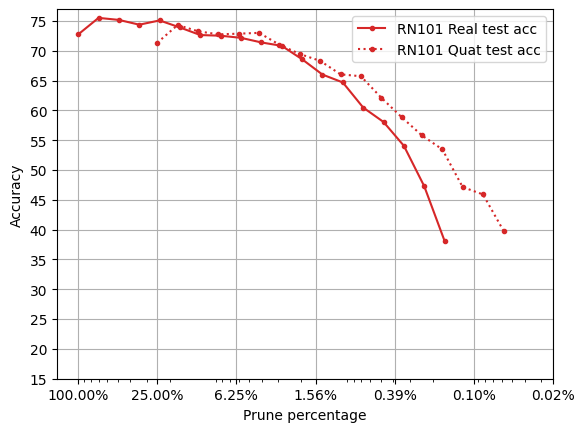

In [37]:
plt.plot(RN101_real_prune_percs[:19], RN101_real_test_accs[:19], linestyle="-", marker=".", color="tab:red", label="RN101 Real test acc")
plt.plot(RN101_quat_prune_percs[:18], RN101_quat_test_accs[:18], linestyle=":", marker=".", color="tab:red", label="RN101 Quat test acc")

plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.25**i for i in range(7)]
plt.xticks(ticks, [f"{t:.2f}%" for t in ticks])
plt.yticks(range(15, 77, 5))
plt.ylim(15, 77)
plt.grid()
plt.savefig("saved_models/RN101.pdf")

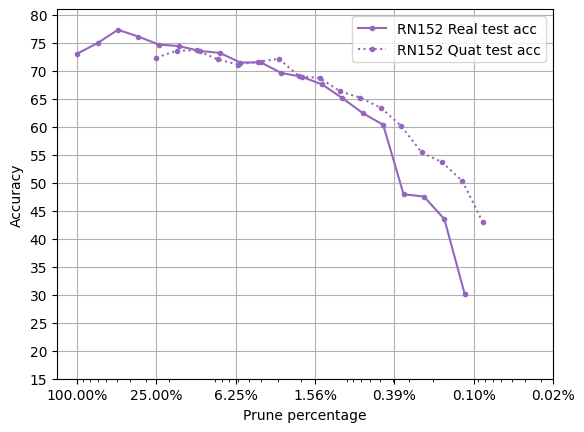

In [38]:
plt.plot(RN152_real_prune_percs[:20], RN152_real_test_accs[:20], linestyle="-", marker=".", color="tab:purple", label="RN152 Real test acc")
plt.plot(RN152_quat_prune_percs[:17], RN152_quat_test_accs[:17], linestyle=":", marker=".", color="tab:purple", label="RN152 Quat test acc")

plt.xscale("log")
plt.legend()
plt.xlabel("Prune percentage")
plt.ylabel("Accuracy")
plt.gca().invert_xaxis()
ticks = [100*0.25**i for i in range(7)]
plt.xticks(ticks, [f"{t:.2f}%" for t in ticks])
plt.yticks(range(15, 81, 5))
plt.ylim(15, 81)
plt.grid()
plt.savefig("saved_models/RN152.pdf")

In [35]:
if not load:
    data = {
        "RN101_real_test_accs": RN101_real_test_accs.tolist(),
        "RN101_real_prune_percs": RN101_real_prune_percs.tolist(),
        "RN101_quat_test_accs": RN101_quat_test_accs.tolist(),
        "RN101_quat_prune_percs": RN101_quat_prune_percs.tolist(),

        "RN152_real_test_accs": RN152_real_test_accs.tolist(),
        "RN152_real_prune_percs": RN152_real_prune_percs.tolist(),
        "RN152_quat_test_accs": RN152_quat_test_accs.tolist(),
        "RN152_quat_prune_percs": RN152_quat_prune_percs.tolist(),
    }

    with open("saved_models/RN101.json", "w") as f:
        json.dump(data, f)
    print("Saved RN101")

Saved RN101


In [30]:
# https://arxiv.org/pdf/2301.04623.pdf
# https://openreview.net/pdf?id=K398CuAKVKB